# Problem 1

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def TC_voltage(V):
    return np.sin(2*np.pi*V)+0.1*np.random.rand(len(V))

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super().__init__()
        self.hidden = nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden1 = nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.predict = nn.Linear(n_hidden, n_output)   # output layer
        self.tan = torch.nn.Tanh()

    def forward(self, x):
        x = self.tan(self.hidden(x))
        x = self.predict(x)
        return x

In [3]:
x_np = np.arange(0, 2, 0.01)
x = torch.tensor(x_np.reshape(-1,1), dtype=torch.float32)
y_np = TC_voltage(x_np)
y = torch.tensor(y_np.reshape(-1,1), dtype=torch.float32)

print(x.shape, y.shape)

torch.Size([200, 1]) torch.Size([200, 1])


In [4]:
def rmse(y, y_pred):
    return torch.sqrt(torch.mean((y - y_pred)**2))

net = Net(n_feature=1, n_hidden=10, n_output=1)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.SmoothL1Loss()  # this is for regression mean squared loss
for t in tqdm(range(2000)):
    prediction = net(x)

    loss = loss_func(y, prediction)
    if loss.item() < 0.001:
        print(f'Early stop at {t} epochs with loss less than 0.001.')
        break

    optimizer.zero_grad()   # clear gradients
    loss.backward()         # backpropagation
    optimizer.step()        # apply gradients

print(f'Epoch {t}: {loss.item()}')
print(f'RMSE: {rmse(y, prediction).item()}')

 78%|███████▊  | 1556/2000 [00:01<00:00, 1546.72it/s]

Early stop at 1556 epochs with loss less than 0.001.
Epoch 1556: 0.000998588977381587
RMSE: 0.04468979686498642


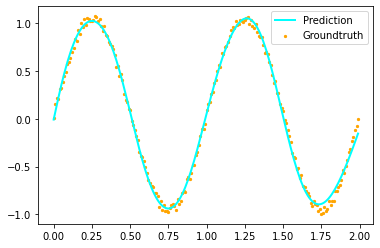

In [5]:
plt.clf()
plt.plot(x.numpy(), prediction.data.numpy(), '-', c='cyan', lw=2, label='Prediction')
plt.scatter(x.numpy(), y.data.numpy(), c='orange', s=5, label='Groundtruth')
plt.legend()
plt.show()

模型訓練1556 epochs後收斂。但最終收斂所需之epoch數與ANN的neuron數量相關，若數量過少，模型不一定可良好的預測，若過多可能會過擬合。

# Problem 2

In [6]:
import torch.utils.data as Data
import scipy.io as sio

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # padding=(kernel_size-1)/2
            ),                              # output shape (16, 28, 28)
            nn.BatchNorm2d(16),             # Batch Normalization
            nn.ReLU(),                      # activation
            # choose max value in 2x2 area, output shape (16, 14, 14)
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.BatchNorm2d(32),             # Batch Normalization
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.fc_layers = nn.Sequential(
            # fully connected layer, output 256 classes
            nn.Linear(32 * 7 * 7, 256),
            nn.ReLU(),                      # activation
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output to (batch_size, 32 * 7 * 7)
        x = x.flatten(1)
        x = self.fc_layers(x)
        output = self.out(x)
        output = nn.functional.softmax(output, dim=1)   # softmax
        return output

In [17]:
EPOCH = 2
BATCH_SIZE = 10
LR = 0.0005

def dataset(mat_contents, category):
    data = np.array([mat_contents[key].astype(float) for key in mat_contents.keys()\
                        if key.startswith(category)])
    
    data_class = np.repeat(range(data.shape[0]), data[0].shape[0]).reshape(10, -1)
    
    data_tensor = torch.tensor(data, dtype=torch.float32).view(-1, 1, 28, 28)
    data_tensor = nn.functional.normalize(data_tensor, dim=1)
    data_class_tensor = torch.tensor(data_class, dtype=torch.int64).view(-1)

    dataset = Data.TensorDataset(data_tensor, data_class_tensor)

    if category == 'train':
        loader = Data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
    else:
        loader = Data.DataLoader(dataset=dataset, shuffle=True)

    return loader

mat_contents = sio.loadmat('/Users/ben/Desktop/Programing/ML/07Homework/07HW2_digit.mat')

train_loader = dataset(mat_contents, 'train')
test_loader = dataset(mat_contents, 'test')

In [18]:
cnn = CNN()
# optimize all cnn parameters
opti = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

test_data = test_loader.dataset.tensors[0]
test_class = test_loader.dataset.tensors[1]

# training and testing
for epoch in range(EPOCH):
    for step, (train_data, train_class) in enumerate(train_loader):   # batch data
        output = cnn(train_data)               # cnn output
        loss = loss_func(output, train_class)   # cross entropy loss
        opti.zero_grad()                    # clear gradients for this training step
        loss.backward()                     # backpropagation
        opti.step()                         # apply gradients

        if step % 100 == 0:
            test_output = cnn(test_data)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_class.data.numpy()).astype(
                int).sum()) / float(test_class.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' %
                  loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

# final accuracy
train_output = cnn(train_data)
pred_y = torch.max(train_output, 1)[1].data.numpy()
train_accuracy = float((pred_y == train_class.data.numpy()).astype(
    int).sum()) / float(train_class.size(0))
test_output = cnn(test_data)
pred_y = torch.max(test_output, 1)[1].data.numpy()
test_accuracy = float((pred_y == test_class.data.numpy()).astype(
    int).sum()) / float(test_class.size(0))
print('learning rate : '+str(LR))
print('batch size : '+str(BATCH_SIZE))
print('EPOCH : '+str(EPOCH))
print('final_test_accuracy : '+str(test_accuracy))
print('final_train_accuracy : '+str(train_accuracy))

Epoch:  0 | train loss: 2.3005 | test accuracy: 0.10
Epoch:  0 | train loss: 1.7859 | test accuracy: 0.72
Epoch:  0 | train loss: 1.6602 | test accuracy: 0.82
Epoch:  0 | train loss: 1.6281 | test accuracy: 0.92
Epoch:  0 | train loss: 1.4680 | test accuracy: 0.93
Epoch:  1 | train loss: 1.4697 | test accuracy: 0.94
Epoch:  1 | train loss: 1.4649 | test accuracy: 0.94
Epoch:  1 | train loss: 1.5657 | test accuracy: 0.95
Epoch:  1 | train loss: 1.5821 | test accuracy: 0.94
Epoch:  1 | train loss: 1.4978 | test accuracy: 0.95
learning rate : 0.0005
batch size : 10
EPOCH : 2
final_test_accuracy : 0.926
final_train_accuracy : 1.0
